In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import warnings
import json
import random
import os


warnings.filterwarnings("ignore")

In [13]:
df = pd.read_csv("my_data/tic_tac_toe_data.csv")

In [14]:
df.head(10)

,annotation_id,annotator,created_at,id,image,label,lead_time,updated_at
0,606,1,2023-09-05T07:20:05.203183Z,720,/data/upload/8/cf46ac44-70_rot.jpg,"[{""x"":34.666666666666686,""y"":30.13333333333331...",148.656,2023-09-05T07:20:05.203212Z
1,607,1,2023-09-05T07:21:54.089276Z,721,/data/upload/8/8f7377a8-71_rot.jpg,"[{""x"":33.733333333333334,""y"":51.2,""width"":6.79...",108.680,2023-09-05T07:21:54.089303Z
2,608,1,2023-09-05T07:22:41.069245Z,722,/data/upload/8/53499f87-72_rot.jpg,"[{""x"":36.13333333333333,""y"":36.4,""width"":11.06...",46.766,2023-09-05T07:22:41.069269Z
3,609,1,2023-09-05T07:23:50.395631Z,723,/data/upload/8/4922da0a-73_rot.jpg,"[{""x"":38.800000000000004,""y"":32,""width"":17.466...",69.104,2023-09-05T07:23:50.395663Z
4,610,1,2023-09-05T07:24:48.140723Z,724,/data/upload/8/9a8442df-74_rot.jpg,"[{""x"":28.4,""y"":24.133333333333333,""width"":14.2...",57.541,2023-09-05T07:24:48.140766Z
5,611,1,2023-09-05T07:26:31.307948Z,725,/data/upload/8/ffbad983-75_rot.jpg,"[{""x"":30,""y"":49.59999999999998,""width"":11.3333...",102.959,2023-09-05T07:26:31.307972Z
6,612,1,2023-09-05T07:27:16.911102Z,726,/data/upload/8/1b791b35-76_rot.jpg,"[{""x"":29.599999999999998,""y"":30.66666666666666...",45.395,2023-09-05T07:27:16.911128Z
7,613,1,2023-09-05T07:28:40.474397Z,727,/data/upload/8/693da503-77_rot.jpg,"[{""x"":19.066666666666666,""y"":26.66666666666666...",83.338,2023-09-05T07:28:40.474419Z
8,614,1,2023-09-05T07:30:28.067852Z,728,/data/upload/8/75950118-78_rot.jpg,"[{""x"":24.8,""y"":32,""width"":18.933333333333334,""...",107.390,2023-09-05T07:30:28.067876Z
9,615,1,2023-09-05T07:32:18.019457Z,729,/data/upload/8/515d0158-79_rot.jpg,"[{""x"":30.266666666666666,""y"":29.86666666666667...",109.730,2023-09-05T07:32:18.019488Z


In [15]:
df.shape

(103, 8)

In [16]:
df = df[["image", "label"]] # leaving only necessary data

In [17]:
df['image'].replace(r'.*/[^-]*-(.*)$', r'\1', regex=True, inplace=True) # replace image path with image file name

In [18]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   103 non-null    object
 1   label   103 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [19]:
json.loads(df.label[0]) # an example of bounding boxes

[{'x': 34.666666666666686,
  'y': 30.13333333333331,
  'width': 14.266666666666655,
  'height': 12.933333333333358,
  'rotation': 0,
  'rectanglelabels': ['1'],
  'original_width': 150,
  'original_height': 150},
 {'x': 60.266666666666644,
  'y': 39.33333333333337,
  'width': 9.466666666666711,
  'height': 11.066666666666611,
  'rotation': 0,
  'rectanglelabels': ['0'],
  'original_width': 150,
  'original_height': 150},
 {'x': 77.33333333333323,
  'y': 45.06666666666666,
  'width': 17.599999999999994,
  'height': 12.53333333333328,
  'rotation': 0,
  'rectanglelabels': ['1'],
  'original_width': 150,
  'original_height': 150},
 {'x': 37.86666666666667,
  'y': 58.13333333333334,
  'width': 16.933333333333337,
  'height': 11.466666666666654,
  'rotation': 0,
  'rectanglelabels': ['1'],
  'original_width': 150,
  'original_height': 150},
 {'x': 63.46666666666667,
  'y': 58.8,
  'width': 14.799999999999997,
  'height': 15.333333333333329,
  'rotation': 0,
  'rectanglelabels': ['1'],
  'or

In [20]:
data = []
data_path = "my_data/rot_images/"
clf_label_dict = {"0": [1, 0, 0], "1": [0, 1, 0], "None": [0, 0, 1]} # ohe (one hot encoding) for our 3 classes "X" "O" "empty box"

In [21]:
for i in range(df.shape[0]):
    rects = json.loads(df.label[i])
    label_tmp = []
    
    for rect in rects:
        label_tmp.append([rect["x"] / 100,
                          rect["y"] / 100,
                          (rect["x"] + rect["width"]) / 100,
                          (rect["y"] + rect["height"]) / 100,
                          *clf_label_dict[rect["rectanglelabels"][0]]])
    
    
    data.append([cv.cvtColor(cv.imread(os.path.join(data_path, df.image[i])), cv.COLOR_BGR2GRAY), label_tmp])
    # data contains sublists and first element of each is an image stored as numpy array
    # and the second if an array of bounding boxes (x1, y1, x2, y2, ohe clf) coords are from 0 to 1
    

In [22]:
np.array(data[0][1]).shape

(9, 7)

In [23]:
random.shuffle(data)

In [24]:
x = np.array(list(map(lambda ins: ins[0], data)))[:, :, :, None] / 255
y = np.array(list(map(lambda ins: np.array(ins[1]).flatten(), data)))

In [25]:
x.shape, y.shape

((103, 150, 150, 1), (103, 63))

# Training

In [17]:
model_tic_tac_toe = tf.keras.Sequential([tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(150, 150, 1)),
                                         tf.keras.layers.BatchNormalization(),
                                         tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), padding="same", activation="relu"),
                                         tf.keras.layers.BatchNormalization(),
                                         tf.keras.layers.MaxPooling2D(2),
                                         tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu"),
                                         tf.keras.layers.BatchNormalization(),
                                         tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu"),
                                         tf.keras.layers.BatchNormalization(),
                                         tf.keras.layers.MaxPooling2D(2),
                                         tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
                                         tf.keras.layers.BatchNormalization(),
                                         tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
                                         tf.keras.layers.BatchNormalization(),
                                         tf.keras.layers.MaxPooling2D(2),
                                         tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
                                         tf.keras.layers.BatchNormalization(),
                                         tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
                                         tf.keras.layers.BatchNormalization(),
                                         tf.keras.layers.MaxPooling2D(2),
                                         tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
                                         tf.keras.layers.BatchNormalization(),
                                         tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
                                         tf.keras.layers.BatchNormalization(),
                                         tf.keras.layers.Flatten(),
                                         tf.keras.layers.Dense(units=256, activation="relu"),
                                         tf.keras.layers.Dropout(0.1),
                                         tf.keras.layers.Dense(units=256, activation="relu"),
                                         tf.keras.layers.Dropout(0.1),
                                         tf.keras.layers.Dense(units=128, activation="relu"),
                                         tf.keras.layers.Dropout(0.1),
                                         tf.keras.layers.Dense(units=63, activation="sigmoid")])

model_tic_tac_toe.compile(optimizer=tf.keras.optimizers.Adam(),
                          loss=tf.keras.losses.Huber(),
                          metrics=["MAE"])

In [27]:
model_tic_tac_toe = tf.keras.models.load_model("models/model_tic_tac_toe_on_my_data.h5")

In [18]:
model_tic_tac_toe.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 8)       80        
                                                                 
 batch_normalization_10 (Bat  (None, 150, 150, 8)      32        
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 150, 150, 8)       584       
                                                                 
 batch_normalization_11 (Bat  (None, 150, 150, 8)      32        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 8)        0         
 2D)                                                             
                                                      

In [19]:
history = model_tic_tac_toe.fit(x, y, epochs=1000, batch_size=32)

Epoch 1/1000
4/4 [==============================] - 2s 112ms/step - loss: 0.0696 - MAE: 0.3067
Epoch 2/1000
4/4 [==============================] - 0s 111ms/step - loss: 0.0568 - MAE: 0.2671
Epoch 3/1000
4/4 [==============================] - 0s 104ms/step - loss: 0.0488 - MAE: 0.2466
Epoch 4/1000
4/4 [==============================] - 0s 104ms/step - loss: 0.0436 - MAE: 0.2287
Epoch 5/1000
4/4 [==============================] - 0s 105ms/step - loss: 0.0394 - MAE: 0.2161
Epoch 6/1000
4/4 [==============================] - 0s 106ms/step - loss: 0.0368 - MAE: 0.2072
Epoch 7/1000
4/4 [==============================] - 0s 109ms/step - loss: 0.0333 - MAE: 0.1963
Epoch 8/1000
4/4 [==============================] - 0s 115ms/step - loss: 0.0304 - MAE: 0.1868
Epoch 9/1000
4/4 [==============================] - 0s 104ms/step - loss: 0.0288 - MAE: 0.1806
Epoch 10/1000
4/4 [==============================] - 1s 111ms/step - loss: 0.0269 - MAE: 0.1745
Epoch 11/1000
4/4 [==============================

4/4 [==============================] - 1s 120ms/step - loss: 0.0016 - MAE: 0.0346
Epoch 171/1000
4/4 [==============================] - 1s 122ms/step - loss: 0.0016 - MAE: 0.0348
Epoch 172/1000
4/4 [==============================] - 1s 119ms/step - loss: 0.0013 - MAE: 0.0323
Epoch 173/1000
4/4 [==============================] - 1s 119ms/step - loss: 0.0013 - MAE: 0.0318
Epoch 174/1000
4/4 [==============================] - 1s 121ms/step - loss: 0.0013 - MAE: 0.0316
Epoch 175/1000
4/4 [==============================] - 1s 119ms/step - loss: 0.0014 - MAE: 0.0330
Epoch 176/1000
4/4 [==============================] - 1s 119ms/step - loss: 0.0014 - MAE: 0.0319
Epoch 177/1000
4/4 [==============================] - 1s 119ms/step - loss: 0.0013 - MAE: 0.0320
Epoch 178/1000
4/4 [==============================] - 1s 120ms/step - loss: 0.0012 - MAE: 0.0315
Epoch 179/1000
4/4 [==============================] - 1s 123ms/step - loss: 0.0013 - MAE: 0.0333
Epoch 180/1000
4/4 [=========================

4/4 [==============================] - 1s 123ms/step - loss: 4.3791e-04 - MAE: 0.0166
Epoch 334/1000
4/4 [==============================] - 1s 120ms/step - loss: 4.1036e-04 - MAE: 0.0166
Epoch 335/1000
4/4 [==============================] - 1s 124ms/step - loss: 3.8257e-04 - MAE: 0.0165
Epoch 336/1000
4/4 [==============================] - 1s 130ms/step - loss: 5.6833e-04 - MAE: 0.0182
Epoch 337/1000
4/4 [==============================] - 1s 128ms/step - loss: 4.6481e-04 - MAE: 0.0175
Epoch 338/1000
4/4 [==============================] - 1s 124ms/step - loss: 5.0446e-04 - MAE: 0.0187
Epoch 339/1000
4/4 [==============================] - 1s 135ms/step - loss: 4.5170e-04 - MAE: 0.0164
Epoch 340/1000
4/4 [==============================] - 1s 129ms/step - loss: 5.1293e-04 - MAE: 0.0175
Epoch 341/1000
4/4 [==============================] - 1s 132ms/step - loss: 4.3777e-04 - MAE: 0.0169
Epoch 342/1000
4/4 [==============================] - 1s 127ms/step - loss: 4.7771e-04 - MAE: 0.0176
Epoch

4/4 [==============================] - 1s 117ms/step - loss: 4.2425e-04 - MAE: 0.0162
Epoch 496/1000
4/4 [==============================] - 1s 122ms/step - loss: 4.5704e-04 - MAE: 0.0157
Epoch 497/1000
4/4 [==============================] - 1s 127ms/step - loss: 4.1599e-04 - MAE: 0.0165
Epoch 498/1000
4/4 [==============================] - 1s 130ms/step - loss: 3.2141e-04 - MAE: 0.0149
Epoch 499/1000
4/4 [==============================] - 1s 126ms/step - loss: 4.1313e-04 - MAE: 0.0165
Epoch 500/1000
4/4 [==============================] - 1s 123ms/step - loss: 4.5261e-04 - MAE: 0.0166
Epoch 501/1000
4/4 [==============================] - 1s 123ms/step - loss: 3.7202e-04 - MAE: 0.0158
Epoch 502/1000
4/4 [==============================] - 1s 121ms/step - loss: 3.9440e-04 - MAE: 0.0155
Epoch 503/1000
4/4 [==============================] - 1s 126ms/step - loss: 4.0499e-04 - MAE: 0.0167
Epoch 504/1000
4/4 [==============================] - 1s 119ms/step - loss: 4.0864e-04 - MAE: 0.0160
Epoch

4/4 [==============================] - 1s 134ms/step - loss: 6.5097e-04 - MAE: 0.0206
Epoch 659/1000
4/4 [==============================] - 1s 132ms/step - loss: 5.9483e-04 - MAE: 0.0195
Epoch 660/1000
4/4 [==============================] - 1s 135ms/step - loss: 6.0143e-04 - MAE: 0.0189
Epoch 661/1000
4/4 [==============================] - 1s 134ms/step - loss: 5.5070e-04 - MAE: 0.0185
Epoch 662/1000
4/4 [==============================] - 1s 133ms/step - loss: 5.2654e-04 - MAE: 0.0189
Epoch 663/1000
4/4 [==============================] - 1s 136ms/step - loss: 6.6272e-04 - MAE: 0.0194
Epoch 664/1000
4/4 [==============================] - 1s 136ms/step - loss: 5.7797e-04 - MAE: 0.0189
Epoch 665/1000
4/4 [==============================] - 1s 133ms/step - loss: 6.8151e-04 - MAE: 0.0180
Epoch 666/1000
4/4 [==============================] - 1s 135ms/step - loss: 5.0951e-04 - MAE: 0.0173
Epoch 667/1000
4/4 [==============================] - 1s 132ms/step - loss: 4.7749e-04 - MAE: 0.0175
Epoch

4/4 [==============================] - 1s 140ms/step - loss: 2.6661e-04 - MAE: 0.0135
Epoch 821/1000
4/4 [==============================] - 1s 139ms/step - loss: 2.8918e-04 - MAE: 0.0140
Epoch 822/1000
4/4 [==============================] - 1s 133ms/step - loss: 2.8722e-04 - MAE: 0.0138
Epoch 823/1000
4/4 [==============================] - 1s 137ms/step - loss: 4.0283e-04 - MAE: 0.0149
Epoch 824/1000
4/4 [==============================] - 1s 131ms/step - loss: 2.9877e-04 - MAE: 0.0143
Epoch 825/1000
4/4 [==============================] - 1s 136ms/step - loss: 3.7491e-04 - MAE: 0.0150
Epoch 826/1000
4/4 [==============================] - 1s 132ms/step - loss: 4.4616e-04 - MAE: 0.0151
Epoch 827/1000
4/4 [==============================] - 1s 140ms/step - loss: 3.7884e-04 - MAE: 0.0158
Epoch 828/1000
4/4 [==============================] - 1s 133ms/step - loss: 4.3281e-04 - MAE: 0.0155
Epoch 829/1000
4/4 [==============================] - 1s 128ms/step - loss: 2.7882e-04 - MAE: 0.0138
Epoch

4/4 [==============================] - 1s 132ms/step - loss: 2.6846e-04 - MAE: 0.0136
Epoch 983/1000
4/4 [==============================] - 1s 132ms/step - loss: 3.3230e-04 - MAE: 0.0146
Epoch 984/1000
4/4 [==============================] - 1s 136ms/step - loss: 3.0024e-04 - MAE: 0.0135
Epoch 985/1000
4/4 [==============================] - 1s 136ms/step - loss: 2.8687e-04 - MAE: 0.0141
Epoch 986/1000
4/4 [==============================] - 1s 132ms/step - loss: 2.9950e-04 - MAE: 0.0142
Epoch 987/1000
4/4 [==============================] - 1s 132ms/step - loss: 3.3084e-04 - MAE: 0.0145
Epoch 988/1000
4/4 [==============================] - 1s 135ms/step - loss: 2.8303e-04 - MAE: 0.0137
Epoch 989/1000
4/4 [==============================] - 1s 135ms/step - loss: 3.9099e-04 - MAE: 0.0147
Epoch 990/1000
4/4 [==============================] - 1s 131ms/step - loss: 3.2532e-04 - MAE: 0.0143
Epoch 991/1000
4/4 [==============================] - 1s 133ms/step - loss: 2.7170e-04 - MAE: 0.0135
Epoch

In [20]:
model_tic_tac_toe.save("models/model_tic_tac_toe_on_my_data.h5")

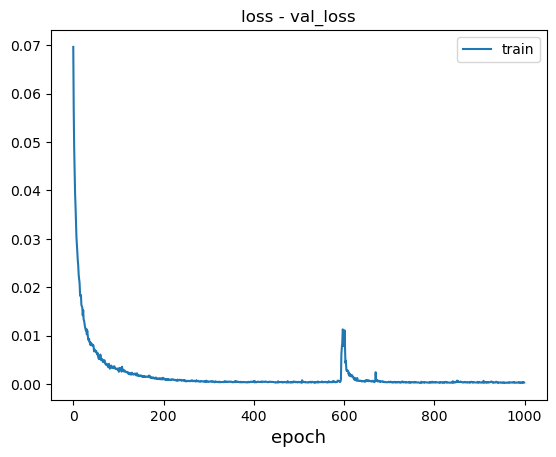

In [21]:
# plotting the history of training
plt.plot(history.history["loss"], label="train")
plt.title("loss - val_loss")
plt.xlabel("epoch", fontsize=13)
plt.legend(bbox_to_anchor=(1.0, 1.0))


plt.show()

In [22]:
# you can change following params 
size = np.array([800, 800]) # size of the output image
i = 100 # index of the image from the train data 
color_dict = {0: (200, 200, 200), 1: (0, 0, 0), 2: (100, 100, 100)} # colors for the classes


while True:
    img = cv.resize(data[i][0], size, interpolation=cv.INTER_LINEAR)
    img_pred_tmp = data[i][0]
    
    
    pred = np.array(model_tic_tac_toe.predict(img_pred_tmp[None] / 255)).reshape((9, 7))
    
    # creating bounding boxes
    for rect in pred:
        color = color_dict[rect[-3:].argmax()]
        cv.rectangle(img, (int(rect[0] * img.shape[1]), int(rect[1] * img.shape[0])), (int(rect[2] * img.shape[1]), int(rect[3] * img.shape[0])), color, thickness=2)

    
    cv.imshow("IMG (press q to quit)", img)
    

    if cv.waitKey(20) & 0xFF == ord("q"):
        break

cv.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step


QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread

1/1 [==============================] - 0s 15ms/step


In [23]:
# you can change these params
image_path = "init_data/images/tic_12.jpg" # path of the input image
color_dict = {0: (0, 150, 0), 1: (0, 0, 200), 2: (100, 100, 100)} # colors for classes

while True:
    img = cv.imread(image_path)
    img_pred_tmp = cv.cvtColor(cv.resize(img, (150, 150), interpolation=cv.INTER_AREA), cv.COLOR_BGR2GRAY)
    
    pred = np.array(model_tic_tac_toe.predict(img_pred_tmp[None] / 255)).reshape((9, 7))
    
    # creating bounding boxes
    for rect in pred:
        color = color_dict[rect[-3:].argmax()]
        cv.rectangle(img, (int(rect[0] * img.shape[1]), int(rect[1] * img.shape[0])), (int(rect[2] * img.shape[1]), int(rect[3] * img.shape[0])), color, thickness=2)

    
    cv.imshow("IMG (press q to quit)", img)
    

    if cv.waitKey(20) & 0xFF == ord("q"):
        break

cv.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step


QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread (0xb546fb0).
Cannot move to target thread (0xa846e50)

QObject::moveToThread: Current thread (0xa846e50) is not the object's thread

1/1 [==============================] - 0s 15ms/step


### The results shows us that our model cannot perform well on unseen data. I assume that our model just does not generalize quite well and we get too bad predictions because low similarity of my data to given one. Getting more data will probably solve it. But I do not have hours to label more data so I will use the given one.

In [28]:
init_df = pd.read_csv("init_data/init_tic_tac_toe_data.csv")

In [29]:
init_df

,annotation_id,annotator,created_at,id,image,label,lead_time,updated_at
0,481,1,2023-09-03T14:03:32.744869Z,708,/data/upload/6/aa0f4add-tic_01.jpg,"[{""x"":29.63814056011206,""y"":16.8,""width"":10.57...",391.323,2023-09-05T19:05:03.882885Z
1,482,1,2023-09-03T14:08:35.606885Z,709,/data/upload/6/c1a7d84a-tic_02.jpg,"[{""x"":24.947901106554607,""y"":12.66666666666666...",535.532,2023-09-05T19:03:36.901411Z
2,483,1,2023-09-03T14:11:06.042702Z,710,/data/upload/6/e3e214d9-tic_03.jpg,"[{""x"":28.141265560112057,""y"":14.66666666666667...",328.060,2023-09-05T19:01:23.888578Z
3,484,1,2023-09-03T14:13:45.294082Z,711,/data/upload/6/49766117-tic_04.jpg,"[{""x"":34.62773167350142,""y"":21.86666666666666,...",301.149,2023-09-05T19:00:15.238001Z
4,485,1,2023-09-03T14:15:14.002022Z,712,/data/upload/6/379e432e-tic_05.jpg,"[{""x"":30.43648167350142,""y"":16.13333333333333,...",1238.171,2023-09-05T18:59:09.393396Z
5,486,1,2023-09-03T14:18:42.167779Z,713,/data/upload/6/ae86aa70-tic_06.jpg,"[{""x"":30.236875,""y"":18.53333333333333,""width"":...",380.696,2023-09-05T18:41:29.416071Z
6,487,1,2023-09-03T14:22:30.141157Z,714,/data/upload/6/e6504ecb-tic_07.jpg,"[{""x"":32.831458333333345,""y"":27.86666666666666...",384.268,2023-09-05T18:40:04.593847Z
7,488,1,2023-09-03T14:28:26.948690Z,715,/data/upload/6/df3df505-tic_08.jpg,"[{""x"":26.644375000000004,""y"":25.46666666666666...",524.828,2023-09-05T18:38:28.736409Z
8,489,1,2023-09-03T14:40:12.581600Z,716,/data/upload/6/e3137e6f-tic_09.jpg,"[{""x"":28.839807226778724,""y"":23.73333333333333...",1029.874,2023-09-05T18:36:51.816165Z
9,490,1,2023-09-03T14:47:44.234599Z,717,/data/upload/6/d49b68e8-tic_10.jpg,"[{""x"":27.64229166666667,""y"":22.133333333333333...",812.120,2023-09-05T18:32:23.083462Z


In [30]:
init_df = init_df[["image", "label"]]

In [31]:
init_df['image'].replace(r'.*/[^-]*-(.*)$', r'\1', regex=True, inplace=True)

In [32]:
data_path = "init_data/images/"
clf_label_dict = {"0": [1, 0, 0], "1": [0, 1, 0], "None": [0, 0, 1]}

In [33]:
for i in range(init_df.shape[0]):
    rects = json.loads(init_df.label[i])
    label_tmp = []
    
    for rect in rects:
        label_tmp.append([rect["x"] / 100,
                          rect["y"] / 100,
                          (rect["x"] + rect["width"]) / 100,
                          (rect["y"] + rect["height"]) / 100,
                          *clf_label_dict[rect["rectanglelabels"][0]]])
    
    
    data.append([cv.resize(cv.cvtColor(cv.imread(os.path.join(data_path, init_df.image[i])), cv.COLOR_BGR2GRAY), (150, 150)), label_tmp])

### I preprocess data in the same way as my data and added it to my data to train on all the images

In [34]:
np.array(data[0][1]).shape

(9, 7)

In [35]:
random.shuffle(data)

In [36]:
x = np.array(list(map(lambda ins: ins[0], data)))[:, :, :, None] / 255
y = np.array(list(map(lambda ins: np.array(ins[1]).flatten(), data)))

In [37]:
x.shape, y.shape

((115, 150, 150, 1), (115, 63))

In [38]:
model_tic_tac_toe = tf.keras.models.load_model("models/model_tic_tac_toe.h5")

In [60]:
history = model_tic_tac_toe.fit(x, y, epochs=100, batch_size=32)

Epoch 1/100
5/5 [==============================] - 1s 125ms/step - loss: 2.4257e-04 - MAE: 0.0125
Epoch 2/100
5/5 [==============================] - 1s 128ms/step - loss: 2.5182e-04 - MAE: 0.0123
Epoch 3/100
5/5 [==============================] - 1s 126ms/step - loss: 2.4183e-04 - MAE: 0.0126
Epoch 4/100
5/5 [==============================] - 1s 128ms/step - loss: 2.1868e-04 - MAE: 0.0116
Epoch 5/100
5/5 [==============================] - 1s 126ms/step - loss: 2.0834e-04 - MAE: 0.0118
Epoch 6/100
5/5 [==============================] - 1s 142ms/step - loss: 2.0391e-04 - MAE: 0.0115
Epoch 7/100
5/5 [==============================] - 1s 126ms/step - loss: 1.9253e-04 - MAE: 0.0111
Epoch 8/100
5/5 [==============================] - 1s 127ms/step - loss: 2.3846e-04 - MAE: 0.0120
Epoch 9/100
5/5 [==============================] - 1s 132ms/step - loss: 2.2951e-04 - MAE: 0.0115
Epoch 10/100
5/5 [==============================] - 1s 148ms/step - loss: 2.6073e-04 - MAE: 0.0118
Epoch 11/100
5/5 [=

In [61]:
model_tic_tac_toe.save("models/model_tic_tac_toe.h5")

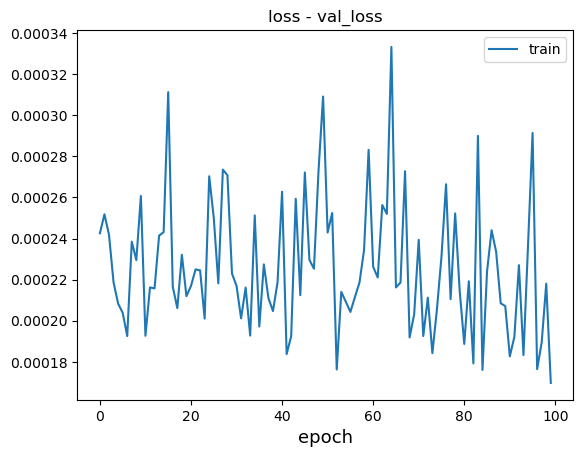

In [62]:
# plotting the history of training
plt.plot(history.history["loss"], label="train")
plt.title("loss - val_loss")
plt.xlabel("epoch", fontsize=13)
plt.legend(bbox_to_anchor=(1.0, 1.0))


plt.show()

In [39]:
# feel free to change these params 
size = np.array([800, 800]) # size of output image
i = 100 # index of an image in data
color_dict = {0: (200, 200, 200), 1: (0, 0, 0), 2: (100, 100, 100)} # colors of different classes


while True:
    img = cv.resize(data[i][0], size, interpolation=cv.INTER_LINEAR)
    img_pred_tmp = data[i][0]
    
    
    pred = np.array(model_tic_tac_toe.predict(img_pred_tmp[None] / 255)).reshape((9, 7))
    
    
    for rect in pred:
        color = color_dict[rect[-3:].argmax()]
        cv.rectangle(img, (int(rect[0] * img.shape[1]), int(rect[1] * img.shape[0])), (int(rect[2] * img.shape[1]), int(rect[3] * img.shape[0])), color, thickness=2)

    
    cv.imshow("IMG (press q to quit)", img)
    

    if cv.waitKey(20) & 0xFF == ord("q"):
        break

cv.destroyAllWindows()

1/1 [==============================] - 0s 183ms/step


1/1 [==============================] - 0s 18ms/step


QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread

1/1 [==============================] - 0s 16ms/step


In [40]:
# function to check if the all the same classes in one row
def same_row(row, winner_type):
    if winner_type in [0, 1]:
        return row[0] == row[1] == row[2] == winner_type

In [42]:
def find_the_winner(pred):
    
    """find_the_winner(pred):
           gets as an input my predictions
           returns an array where first 4 elements are to store coords to draw a line and 5th is for class
    
    """
    types = pred[:, -3:].argmax(axis=1).reshape((3, 3))
    pred_tmp = pred.reshape((3, 3, 7))
    
    for i in range(3):
        if same_row(types[:, i], types[0, i]):
            pred_tmp = pred_tmp[:, i]
            line_c = np.array([(pred_tmp[0, 0] + pred_tmp[0, 2]) / 2, pred_tmp[0, 1], (pred_tmp[2, 0] + pred_tmp[2, 2]) / 2, pred_tmp[2, 3], types[0, i]])
            return line_c
        
        if same_row(types[i, :], types[i, 0]):
            pred_tmp = pred_tmp[i, :]
            line_c = np.array([pred_tmp[0, 0], (pred_tmp[0, 1] + pred_tmp[0, 3]) / 2, pred_tmp[2, 2], (pred_tmp[2, 1] + pred_tmp[2, 3]) / 2, types[i, 0]])
            return line_c
        
    if same_row([types[i, i] for i in range(3)], types[0, 0]):
        pred_tmp = np.array([pred_tmp[i, i] for i in range(3)])
        line_c = np.array([pred_tmp[0, 0], pred_tmp[0, 1], pred_tmp[2, 2], pred_tmp[2, 3], types[0, 0]])
        return line_c
    
    if same_row([types[i, 2 - i] for i in range(3)], types[0, 2]):
        pred_tmp = np.array([pred_tmp[i, 2 - i] for i in range(3)])
        line_c = np.array([pred_tmp[0, 2], pred_tmp[0, 1], pred_tmp[2, 0], pred_tmp[2, 3],  types[0, 2]])
        return line_c

In [43]:
# feel free to change these params
image_path = "init_data/images/tic_06.jpg" # path to the input image
color_dict = {0: (0, 150, 0), 1: (0, 0, 200), 2: (100, 100, 100)} # color of classes


WINNER_DICT = {0: "O", 1: "X"}

while True:
    img = cv.imread(image_path)
    img_pred_tmp = cv.cvtColor(cv.resize(img, (150, 150), interpolation=cv.INTER_AREA), cv.COLOR_BGR2GRAY)
    
    pred = np.array(model_tic_tac_toe.predict(img_pred_tmp[None] / 255)).reshape((9, 7))
    
    winner = find_the_winner(pred)
    
    if winner is not None:
        winner_sing = "the winner is " + WINNER_DICT[winner[-1]]
    else:
        winner_sing = "there is no winner "

    for rect in pred:
        color = color_dict[rect[-3:].argmax()]
        cv.rectangle(img, (int(rect[0] * img.shape[1]), int(rect[1] * img.shape[0])), (int(rect[2] * img.shape[1]), int(rect[3] * img.shape[0])), color, thickness=2)
    
    if winner is not None:
        cv.line(img, (int(winner[0] * img.shape[1]), int(winner[1] * img.shape[0])), (int(winner[2] * img.shape[1]), int(winner[3] * img.shape[0])), color_dict[winner[-1]], thickness=5)
    
    cv.imshow(f"IMG {winner_sing} (press q to quit)", img)
    

    if cv.waitKey(20) & 0xFF == ord("q"):
        break

cv.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step


QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread (0x83697e0).
Cannot move to target thread (0x61c9c70)

QObject::moveToThread: Current thread (0x61c9c70) is not the object's thread

1/1 [==============================] - 0s 15ms/step


In [31]:
# code that creates images with line that crosses the winner for all given ones and saves them

image_path = "init_data/images/"
color_dict = {0: (0, 150, 0), 1: (0, 0, 200), 2: (100, 100, 100)}
WINNER_DICT = {0: "O", 1: "X"}

for image_name in os.listdir(image_path):
    img = cv.imread(os.path.join(image_path, image_name))
    img_pred_tmp = cv.cvtColor(cv.resize(img, (150, 150), interpolation=cv.INTER_AREA), cv.COLOR_BGR2GRAY)
    
    pred = np.array(model_tic_tac_toe.predict(img_pred_tmp[None] / 255)).reshape((9, 7))
    
    winner = find_the_winner(pred)
    
    if winner is not None:
        winner_sing = "the_winner_is_" + WINNER_DICT[winner[-1]]
    else:
        winner_sing = "there_is_no_winner"
   
    if winner is not None:
        cv.line(img, (int(winner[0] * img.shape[1]), int(winner[1] * img.shape[0])), (int(winner[2] * img.shape[1]), int(winner[3] * img.shape[0])), color_dict[winner[-1]], thickness=5)
    
    
    cv.imwrite(os.path.join("init_data_finished_game/", f"{image_name[:-4]}{winner_sing}.jpg"), img)


1/1 [==============================] - 0s 17ms/step
